In [1]:
import pandas as pd
import torch
import requests
import gffutils
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
import importlib
import os
sys.path.append("../")


import src.normalization  
importlib.reload(src.normalization)
from src.normalization import size_factor_normalization

from src.sizeFactor import size_factor_expressed
from src.preprocessing import get_gene_length
from src.thetaMethodOfMoments import robust_method_of_moments_theta


import src.pca_init
import src.autoencoder
importlib.reload(src.autoencoder)
importlib.reload(src.pca_init)
from src.pca_init import pca_init
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

torch.set_num_threads(64)


Read the read count matrix (genes x samples) of whole blood tissue

In [2]:

whole_blood_gct ="../data/gene_reads_whole_blood.gct"

df = pd.read_csv(
    whole_blood_gct,
    sep='\t',
    skiprows=2,
    index_col='id',
    dtype={'Name':'category', 'Description':'category'}
)


Raw counts of ill datat with GeneID with numerical value

In [3]:
sick_data = "../data/GSE157103_raw_counts_GRCh38.p13_NCBI.tsv"
sick_counts = pd.read_csv(
    sick_data,
    sep='\t',
    index_col="GeneID",
    dtype=str
)



Annotations from numerical GeneID to symbol that matches the GTEx data

In [4]:

annot = pd.read_csv(
    "../data/Human.GRCh38.p13.annot.tsv",
    sep='\t',
    dtype=str
)
#matching type of GeneID in sick_counts and annot
sick_counts.index = sick_counts.index.astype(str).str.strip()
annot["GeneID"] = annot["GeneID"].astype(str).str.strip()


symbol_map = (annot[["GeneID", "Symbol"]].drop_duplicates().set_index("GeneID")["Symbol"])


sick_counts_symbol = sick_counts.join(symbol_map, how="left")

sick_counts_symbol.reset_index(inplace=True)  # make GeneID a column

cols = ["GeneID", "Symbol"] + [col for col in sick_counts_symbol.columns if col not in ["GeneID", "Symbol"]]
sick_counts_with_symbol = sick_counts_symbol[cols]



In [5]:
# symbol_id = (annot[["GeneID", "Symbol"]].drop_duplicates().set_index("GeneID")["Symbol"])
# sick_counts.index = sick_counts.index.astype(str) # match the type 


# #
# sick_counts["Symbol"] = sick_counts.index.map(symbol_id)
# sick_counts = sick_counts.dropna(subset=["Symbol"])
# cols = ["Symbol"]+[c for c in sick_counts.columns if c != "Symbol"]
# sick_counts = sick_counts[cols]

# print(sick_counts.shape)


Reading the metadata file from the GTEx website

In [6]:


# URL of the file (right-click the download button and "Copy link address")
url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"

filename_gtex_analysis = "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"

if not os.path.exists(filename_gtex_analysis):
    print("Downloading file ...")
    
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Check for errors


    with open(filename_gtex_analysis, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("File downloaded successfully!")
else:
    print("Working with local copy")

Working with local copy


Reading the metadata and filtering just the samples from whole blood and getting rid of the ones with RIN smaller than 5.7.

Filter out samples with small RIN from the read-count matrix


In [7]:
meta = pd.read_csv("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t")


filtered_meta = meta[(meta["SMTSD"] == 'Whole Blood') & (meta["SMRIN"] >=5.7)]


sample_ids = filtered_meta["SAMPID"].tolist()


print(len(sample_ids))


cols_ = ["Name", "Description"]


cols_+= [col for col in df.columns if col in sample_ids]

df_filtered = df[cols_]



print(len(df.columns))

928
757


In [8]:
print(df_filtered.shape)
print(df_filtered.head(10))

(56200, 755)
                 Name   Description  GTEX-111YS-0006-SM-5NQBE  \
id                                                              
0   ENSG00000223972.5       DDX11L1                         1   
1   ENSG00000227232.5        WASH7P                        55   
2   ENSG00000278267.1     MIR6859-1                         0   
3   ENSG00000243485.5   MIR1302-2HG                         0   
4   ENSG00000237613.2       FAM138A                         0   
5   ENSG00000268020.3        OR4G4P                         0   
6   ENSG00000240361.1       OR4G11P                         1   
7   ENSG00000186092.4         OR4F5                         0   
8   ENSG00000238009.6  RP11-34P13.7                         2   
9   ENSG00000233750.3        CICP27                       105   

    GTEX-1122O-0005-SM-5O99J  GTEX-1128S-0005-SM-5P9HI  \
id                                                       
0                          1                         1   
1                         70    

Create database for the gtf file

In [9]:


gtf_file = "../data/gencode.v26.GRCh38.genes.gtf"

dbfn = "genes.db"

if not os.path.exists(dbfn):

    db = gffutils.create_db(gtf_file, dbfn=dbfn, 
                            force=True, keep_order=True, 
                            merge_strategy="merge", 
                            disable_infer_transcripts=True, 
                            disable_infer_genes=True)
else:
    db = gffutils.FeatureDB(dbfn)
    



In [10]:
#df_filtered contains

#from preprocessing import get_gene_length



gene_length = []


for gene in range(len(df_filtered.iloc[:, 2:])):
    gene_id = str(df_filtered.iloc[gene, 0])
    gene_length.append(get_gene_length(gene_id, db))
    
gene_length = np.array(gene_length)




Delete genes that are not contained in the healthy genes 

In [11]:





# healthy_symbol = set(gene_name[:, 1])


# sick_counts = sick_counts[sick_counts["Symbol"].isin(healthy_symbol)]

# sick_counts_raw = sick_counts.iloc[:, 1:].to_numpy(dtype='float64')


# sick_geneids = set(sick_counts.index)


# symbol_id = symbol_id[symbol_id.index.isin(sick_geneids)]

# geneid_to_symbol = {str(geneid): str(symbol) for geneid, symbol in symbol_id.items()}

# print(len(geneid_to_symbol))



Calculations of fpkm values for the healthy data

In [12]:
gene_name = df_filtered[['Name', 'Description']].to_numpy(dtype='str')

sample_lengths = df_filtered.iloc[:, 2:].sum()


raw_counts  = df_filtered.iloc[:, 2:].to_numpy(dtype='float64')



counts_fpkm = raw_counts*1e9


counts_fpkm = counts_fpkm/sample_lengths.values[np.newaxis, :]


counts_fpkm = counts_fpkm/ gene_length[:, np.newaxis]



 




"We then filtered for expressed genes, defined as genes for which at least 5% of the samples had a FPKM value greater than 1 . Additionally, we discarded genes that had zero counts in more than 75% of the samples."



In [13]:
fpkm_theshold = 1

sample_number = counts_fpkm.shape[1]

fpkm_percent = 0.95*sample_number

zero_percent = 0.75*sample_number

mask_fpkm = (counts_fpkm>=fpkm_theshold).sum(axis=1) >= fpkm_percent

mask_zero = (counts_fpkm==0).sum(axis=1) <=zero_percent

expressed_genes = raw_counts[mask_fpkm & mask_zero,:]
expressed_genes_names = gene_name[mask_fpkm & mask_zero,:]

print(expressed_genes.shape)

non_expressed = raw_counts[~(mask_fpkm&mask_zero),:]
non_expressed_names = gene_name[~(mask_fpkm&mask_zero), :]

print(non_expressed.shape)





(6261, 753)
(49939, 753)


Splitting the sick data into expressed and non-expressed genes with the help of the fpkm normalized counts

In [14]:
sick_fpkm  = pd.read_csv(
    "../data/GSE157103_norm_counts_FPKM_GRCh38.p13_NCBI.tsv",
    sep='\t',
    index_col="GeneID"
)
# print(sick_fpkm)
sick_fpkm.index = sick_fpkm.index.astype(str)


sick_fpkm_np = sick_fpkm.to_numpy(dtype='float64')

fpkm_theshold = 1

sample_number = sick_fpkm_np.shape[1]

fpkm_percent = 0.95*sample_number

zero_percent = 0.75*sample_number

mask_fpkm = (sick_fpkm_np>=fpkm_theshold).sum(axis=1) >= fpkm_percent

mask_zero = (sick_fpkm_np==0).sum(axis=1) <=zero_percent

sick_metadata = sick_counts_symbol[["GeneID", "Symbol"]].to_numpy(dtype='str')

sick_raw = sick_counts_symbol.drop(columns=["GeneID", "Symbol"]).to_numpy(dtype='float64')

sick_expressed_metadata = sick_metadata[mask_fpkm & mask_zero, :]

sick_expressed = sick_raw[mask_fpkm & mask_zero, :]

sick_nonexpressed_metadata = sick_metadata[~(mask_fpkm & mask_zero), :]
sick_nonexpressed = sick_raw[~(mask_fpkm & mask_zero), :]  



print(sick_expressed.shape)
print(sick_nonexpressed.shape)
# expressed_genes_sick = sick_counts_raw[mask_fpkm & mask_zero,:]


# print(expressed_genes_sick.shape)

# non_expressed_sick = sick_counts_raw[~(mask_fpkm&mask_zero),:]

# print(non_expressed_sick.shape)

(8199, 126)
(31177, 126)


In [15]:


healthy_expressed_symbols = set(expressed_genes_names[:, 1])
sick_expressed_symbols = set(sick_expressed_metadata[:, 1])


common_expressed_symbols = healthy_expressed_symbols & sick_expressed_symbols
common_expressed_symbols_ordered = [symbol for symbol in expressed_genes_names[:, 1] if symbol in common_expressed_symbols]


healthy_expressed_mask = np.isin(expressed_genes_names[:, 1], common_expressed_symbols_ordered)
expressed_genes_matched = expressed_genes[healthy_expressed_mask, :]
expressed_genes_names_matched = expressed_genes_names[healthy_expressed_mask, :]


sick_symbol_to_idx = {symbol: i for i, symbol in enumerate(sick_expressed_metadata[:, 1])}
sick_indices = [sick_symbol_to_idx[symbol] for symbol in common_expressed_symbols_ordered]
sick_expressed_matched = sick_expressed[sick_indices, :]
sick_expressed_metadata_matched = sick_expressed_metadata[sick_indices, :]

print("Matched expressed healthy:", expressed_genes_matched.shape)
print("Matched expressed sick:", sick_expressed_matched.shape)

healthy_nonexpr_symbols = set(non_expressed_names[:, 1])
sick_nonexpr_symbols = set(sick_nonexpressed_metadata[:, 1])
common_nonexpr_symbols = healthy_nonexpr_symbols & sick_nonexpr_symbols
common_nonexpr_symbols_ordered = [symbol for symbol in non_expressed_names[:, 1] if symbol in common_nonexpr_symbols]

healthy_nonexpr_mask = np.isin(non_expressed_names[:, 1], common_nonexpr_symbols_ordered)
non_expressed_matched = non_expressed[healthy_nonexpr_mask, :]
non_expressed_names_matched = non_expressed_names[healthy_nonexpr_mask, :]

sick_nonexpr_symbol_to_idx = {symbol: i for i, symbol in enumerate(sick_nonexpressed_metadata[:, 1])}
sick_nonexpr_indices = [sick_nonexpr_symbol_to_idx[symbol] for symbol in common_nonexpr_symbols_ordered]
sick_nonexpressed_matched = sick_nonexpressed[sick_nonexpr_indices, :]
sick_nonexpressed_metadata_matched = sick_nonexpressed_metadata[sick_nonexpr_indices, :]

print("Matched non-expressed healthy:", non_expressed_matched.shape)
print("Matched non-expressed sick:", sick_nonexpressed_matched.shape)

Matched expressed healthy: (5409, 753)
Matched expressed sick: (5409, 126)
Matched non-expressed healthy: (17001, 753)
Matched non-expressed sick: (17001, 126)


In [16]:
print(expressed_genes_matched.shape)
print(expressed_genes_names_matched.shape)

print(non_expressed_matched.shape)
print(non_expressed_names_matched.shape)

print(sick_expressed_matched.shape)
print(sick_expressed_metadata_matched.shape)


print(sick_nonexpressed_matched.shape)
print(sick_nonexpressed_metadata_matched.shape)

(5409, 753)
(5409, 2)
(17001, 753)
(17001, 2)
(5409, 126)
(5409, 2)
(17001, 126)
(17001, 2)


(61,)


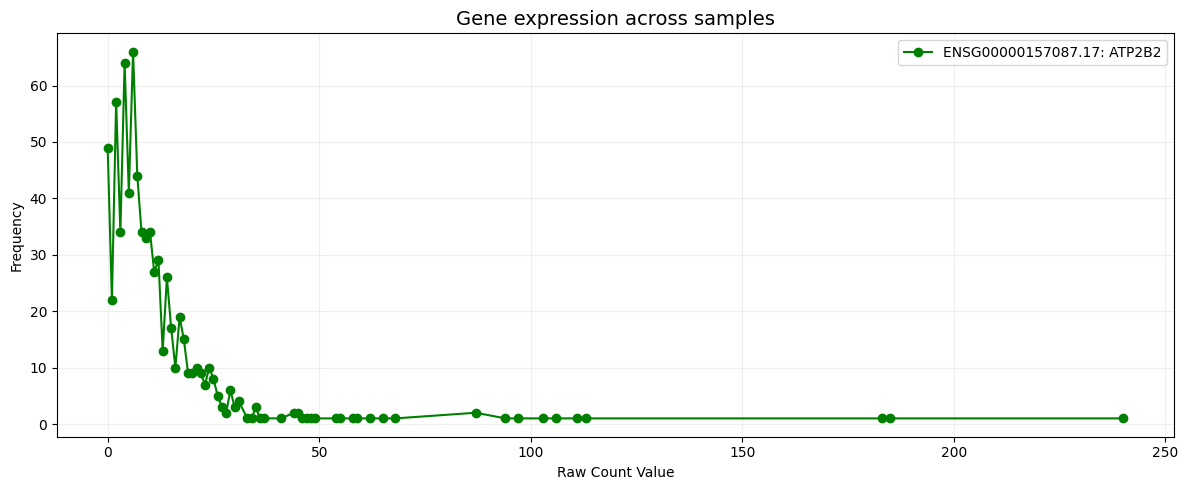

In [17]:


i = random.randint(0, non_expressed_matched.shape[0]-1)
gene_expression = non_expressed_matched[i, :]
unique_counts, frequencies = np.unique(gene_expression, return_counts=True)
print(unique_counts.shape)
gene_id, gene_desc = non_expressed_names_matched[i]

sorted_indices = np.argsort(unique_counts)
unique_counts_sorted = unique_counts[sorted_indices]
frequencies_sorted = frequencies[sorted_indices]

 
plt.figure(figsize=(12, 5))
plt.plot(unique_counts_sorted, frequencies_sorted, color='green', marker='o', label=f"{gene_id}: {gene_desc}")
plt.title("Gene expression across samples", fontsize=14)
plt.xlabel("Raw Count Value", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
# plt.scatter(unique_counts, frequencies, color='green', label=f"{gene_id}: {gene_desc}")
# plt.title("gene expression across samples", fontsize=14)
# plt.xlabel("Expression Count Value", fontsize=10)
# plt.ylabel("Frequency", fontsize=10)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout() 
plt.show()


Calculating the size factors which capture variations in sequencing depth; estimated as the median of the ratios of the gene read counts to their geometric means

In [18]:


print(expressed_genes_matched.shape)

size_factors = size_factor_expressed(expressed_genes_matched)

x, bias = size_factor_normalization(expressed_genes_matched, size_factors)
print(x.shape) 
print(bias.shape)


(5409, 753)
(5409, 753)
(5409, 1)


Plots for checking the  mean-variance relationship for expressed and non expressed 

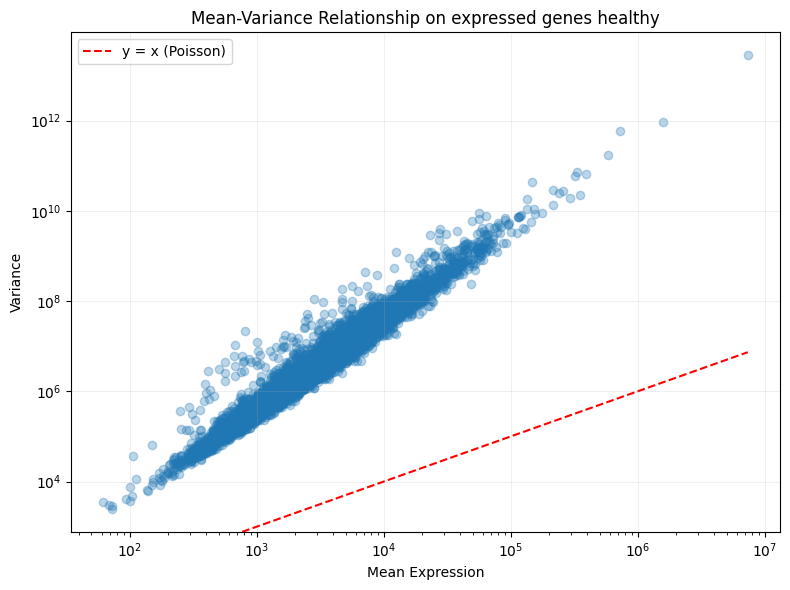

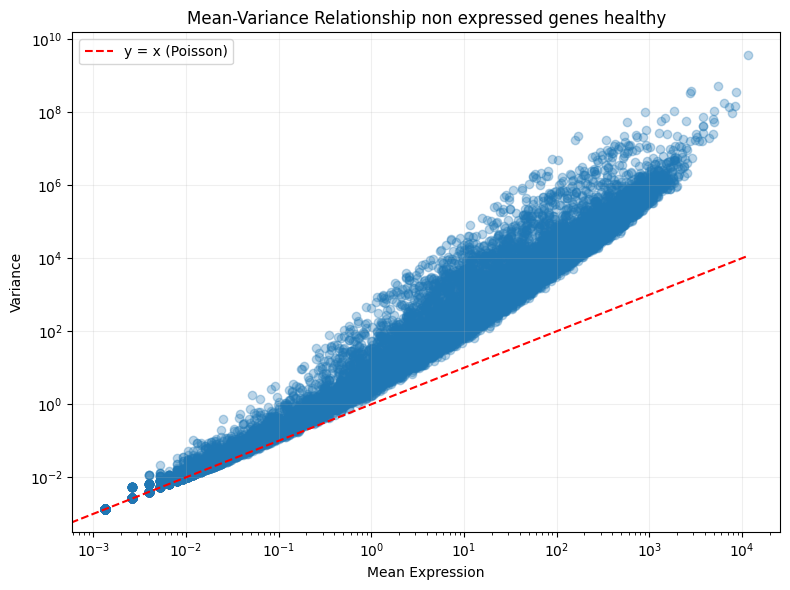

In [19]:



means = expressed_genes_matched.mean(axis=1)
variances = expressed_genes_matched.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship on expressed genes healthy")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()


means = non_expressed_matched.mean(axis=1)
variances = non_expressed_matched.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship non expressed genes healthy")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()




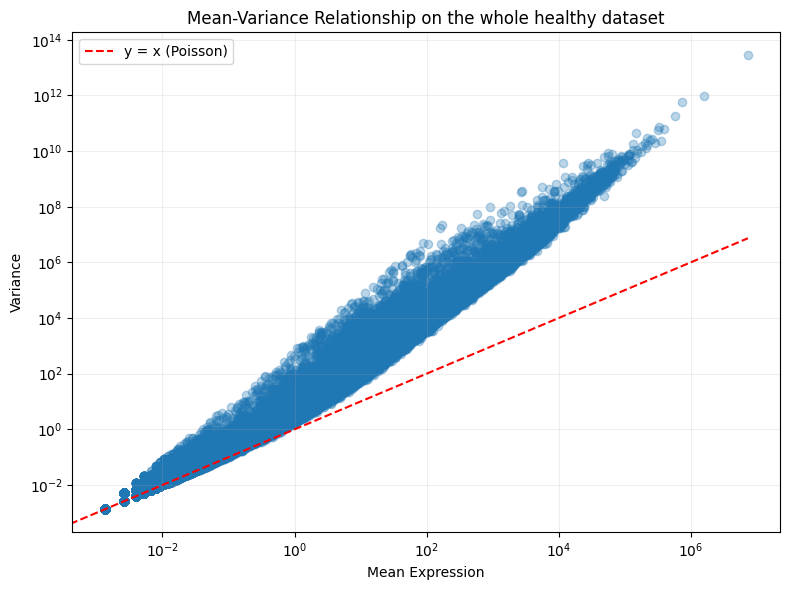

In [20]:



means = raw_counts.mean(axis=1)
variances = raw_counts.var(axis=1, ddof=1)

plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.3)
plt.plot([0, max(means)], [0, max(means)], 'r--', label='y = x (Poisson)')
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.title("Mean-Variance Relationship on the whole healthy dataset")
plt.legend()
plt.grid(alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()




Check of zero rates in the non expressed genes

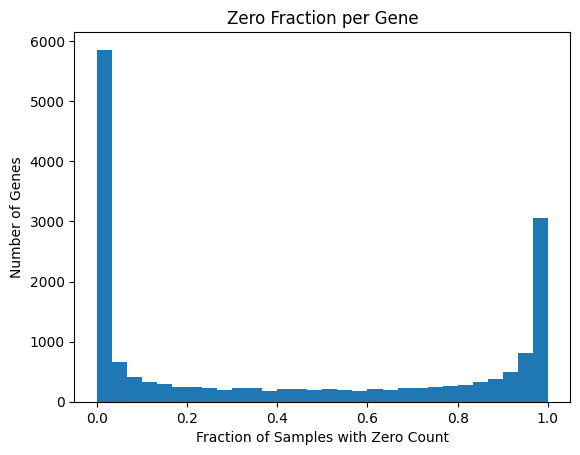

In [21]:
zero_fractions = np.mean(non_expressed_matched == 0, axis=1)
plt.hist(zero_fractions, bins=30)
plt.title("Zero Fraction per Gene")
plt.xlabel("Fraction of Samples with Zero Count")
plt.ylabel("Number of Genes")
plt.show()


In [22]:


#size factors are strictly positive

print(np.sum(size_factors <0)) 

theta = robust_method_of_moments_theta(expressed_genes_matched)

print(np.sum(theta<0))



0
0


Check the sizes of all the initialization matrixes

In [23]:





print(theta.shape)

print(expressed_genes_matched.shape)
print(x.shape)
# print(W_e.shape)
# print(W_d.shape)
print(size_factors.shape)
print(bias.shape)
print(expressed_genes_matched.shape[1])









(5409,)
(5409, 753)
(5409, 753)
(753,)
(5409, 1)
753


Training: 100%|██████████| 50/50 [04:08<00:00,  4.98s/it]


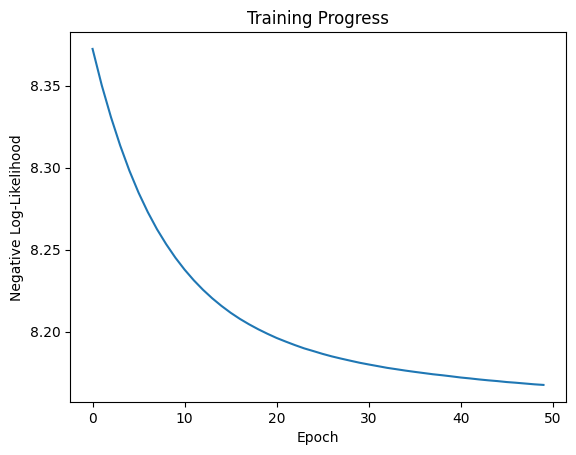

In [24]:

torch.set_num_threads(120)
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.autoencoder)
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

latent_dimension = 16

W_e, W_d = pca_init(expressed_genes_matched.T, latent_dimension)


encoder_16 = EncoderExpressed(expressed_genes_matched.shape[0], W_e.T, latent_dimension)

decoder_16 = DecoderExpressed(W_d.T, bias, expressed_genes_matched.shape[0], latent_dimension)



autoencoder_16 = AutoencoderExpressed(encoder=encoder_16, decoder=decoder_16, theta=theta, size_factors=size_factors)

X = torch.tensor(x.T, dtype=torch.float32)
K = torch.tensor(expressed_genes_matched.T, dtype=torch.float32)

loss = autoencoder_16.fit(X, K, n_epochs=50)


loss_values = [l.detach().cpu().item() for l in loss]

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Progress")
plt.show()

In [25]:


import sys
import importlib
import os
sys.path.append("../")
from src import getDimension
importlib.reload(src.getDimension)
importlib.reload(src.normalization)
from src.normalization import size_factor_normalization
from src.getDimension import inject_outliers, compute_auc_pr, compute_pvalues

outlier_matrix, mask = inject_outliers(expressed_genes_matched, size_factors=size_factors)

outlier_matrix_norm, _ = size_factor_normalization(outlier_matrix, size_factors)

outliers = torch.tensor(outlier_matrix_norm.T, dtype=torch.float32)









In [26]:
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.getDimension)
from src.getDimension import compute_auc_pr, compute_pvalues

mu_trained = autoencoder_16.get_mu(autoencoder_16.forward(outliers)).detach().cpu().numpy().T

theta_trained = autoencoder_16.get_theta().detach().cpu().numpy()


pvals = compute_pvalues(outlier_matrix, mu_trained, theta_trained)

auc_16 = compute_auc_pr(mask.flatten(), pvals.flatten())
print(auc_16)

0.9999124478971142


Training: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


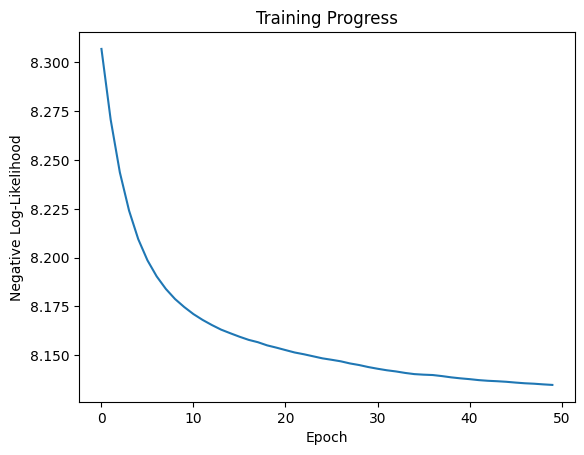

0.9998897794264802


In [27]:

torch.set_num_threads(64)
import sys
import importlib
import os
sys.path.append("../")

importlib.reload(src.autoencoder)
from src.autoencoder import EncoderExpressed, DecoderExpressed, AutoencoderExpressed

latent_dimension = 64

W_e, W_d = pca_init(expressed_genes_matched.T, latent_dimension)


encoder_64 = EncoderExpressed(expressed_genes_matched.shape[0], W_e.T, latent_dimension)

decoder_64 = DecoderExpressed(W_d.T, bias, expressed_genes_matched.shape[0], latent_dimension)



autoencoder_64 = AutoencoderExpressed(encoder=encoder_64, decoder=decoder_64, theta=theta, size_factors=size_factors)

X = torch.tensor(x.T, dtype=torch.float32)
K = torch.tensor(expressed_genes_matched.T, dtype=torch.float32)

loss = autoencoder_64.fit(X, K, n_epochs=50)


loss_values = [l.detach().cpu().item() for l in loss]

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Progress")
plt.show()

importlib.reload(src.getDimension)
from src.getDimension import compute_auc_pr, compute_pvalues

mu_trained_64 = autoencoder_64.get_mu(autoencoder_64.forward(outliers)).detach().cpu().numpy().T

theta_trained_64 = autoencoder_64.get_theta().detach().cpu().numpy()


pvals = compute_pvalues(outlier_matrix, mu_trained_64, theta_trained_64)

auc_64 = compute_auc_pr(mask.flatten(), pvals.flatten())

print(auc_64)

In [99]:
import sys
import importlib


import src.sizeFactor
import src.thetaMethodOfMoments
sys.path.append("../")

importlib.reload(src.thetaMethodOfMoments)
from src.thetaMethodOfMoments import robust_method_of_moments_theta 

theta_non_expressed = robust_method_of_moments_theta(non_expressed_matched)



Z = autoencoder_16.get_latent(X.detach().clone().float()).detach().cpu().numpy()
print(Z.shape)

print(theta_non_expressed.shape)

(753, 16)
(17001,)


In [29]:



Z_torch = torch.tensor(Z, dtype=torch.float32)
print("Z_torch stats:", Z_torch.min().item(), Z_torch.max().item(), Z_torch.mean().item())
non_expressed_matched_torch = torch.tensor(non_expressed_matched.T, dtype=torch.float32)
size_factors_torch = torch.tensor(size_factors, dtype=torch.float32)

print("non_expressed_matched_torch stats:", non_expressed_matched_torch.min().item(), non_expressed_matched_torch.max().item(), non_expressed_matched_torch.mean().item())
print("size_factors_torch stats:", size_factors_torch.min().item(), size_factors_torch.max().item(), size_factors_torch.mean().item())
print("theta_non_expressed stats:", np.min(theta_non_expressed), np.max(theta_non_expressed), np.mean(theta_non_expressed))

Z_torch stats: -15.20988655090332 15.513287544250488 1.2110904279438728e-08
non_expressed_matched_torch stats: 0.0 1349596.0 95.93610382080078
size_factors_torch stats: 0.11040423065423965 4.456681728363037 1.117340326309204
theta_non_expressed stats: 0.021498441363001178 1000.0 277.4576896139719


In [ ]:
import sys
import importlib

sys.path.append("../")

import src.ZINB

importlib.reload(src.ZINB)
from src.ZINB import ZINBHeads

zinb_head = ZINBHeads(
    q = Z.shape[1],
    p0 = non_expressed_matched.shape[0],
    # theta_init=theta_non_expressed
)
# Stage 1: Fit mu and theta, freeze pi
zinb_head.W_pi.requires_grad = False
zinb_head.b_pi.requires_grad = False

loss1  = losses_stage1 = zinb_head.fit(
    Z_torch, non_expressed_matched_torch, size_factors=size_factors_torch,
    n_epochs=30, lr_mu=1e-2, lr_pi=0.0, lr_theta=1e-2
)

# Stage 2: Fit pi, freeze mu and theta
zinb_head.W_mu.requires_grad = False
zinb_head.b_mu.requires_grad = False
zinb_head.log_theta.requires_grad = False
zinb_head.W_pi.requires_grad = True
zinb_head.b_pi.requires_grad = True

loss2 = losses_stage2 = zinb_head.fit(
    Z_torch, non_expressed_matched_torch, size_factors=size_factors_torch,
    n_epochs=10, lr_mu=0.0, lr_pi=5e-4, lr_theta=0.0
)

# Stage 3: Fine-tune all together (optional: use lower lr for pi)
zinb_head.W_mu.requires_grad = True
zinb_head.b_mu.requires_grad = True
zinb_head.W_pi.requires_grad = True
zinb_head.b_pi.requires_grad = True
zinb_head.log_theta.requires_grad = True

loss3 = zinb_head.fit(
    Z_torch, non_expressed_matched_torch, size_factors=size_factors_torch,
    n_epochs=200, lr_mu=5e-3, lr_pi=5e-4, lr_theta=5e-3
)

losses = list(losses_stage1) + list(losses_stage2) + list(loss3)
# losses  = zinb_head.fit(Z_torch, non_expressed_matched_torch, size_factors=size_factors_torch, n_epochs=50,
#                         lr_mu=1e-1, lr_pi=1e-3, lr_theta=1e-1)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Training: 100%|██████████| 200/200 [01:22<00:00,  2.42it/s]


In [120]:
print(len(losses))
print(losses[159])

240
tensor(2.6107e+08)


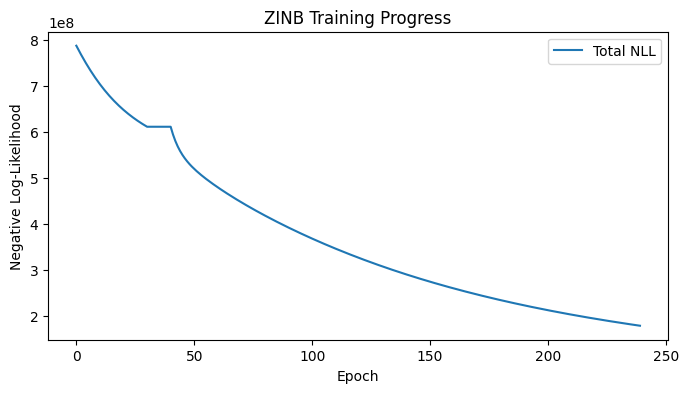

In [121]:
num_datapoints = non_expressed_matched_torch.numel()
loss_values = [l.detach().cpu().item() for l in losses]

loss_per_datapoint = [lv / num_datapoints for lv in loss_values]

plt.figure(figsize=(8,4))
plt.plot(loss_values, label='Total NLL')
# plt.plot(loss_per_datapoint, label='NLL per data point')
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("ZINB Training Progress")
plt.legend()
plt.show()

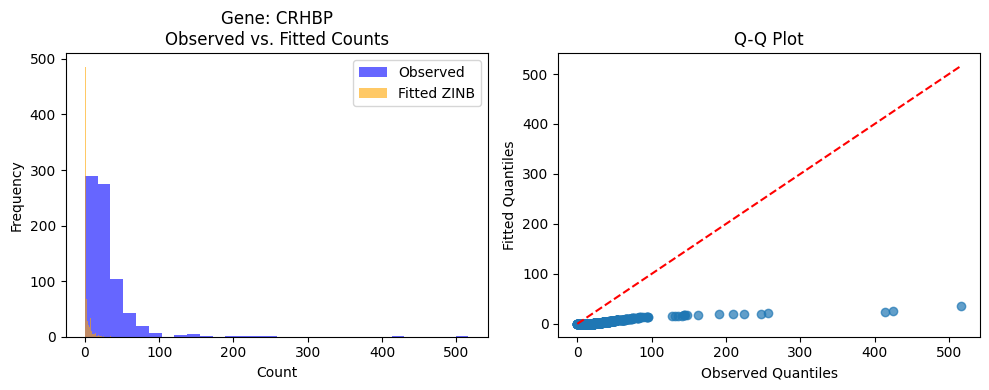

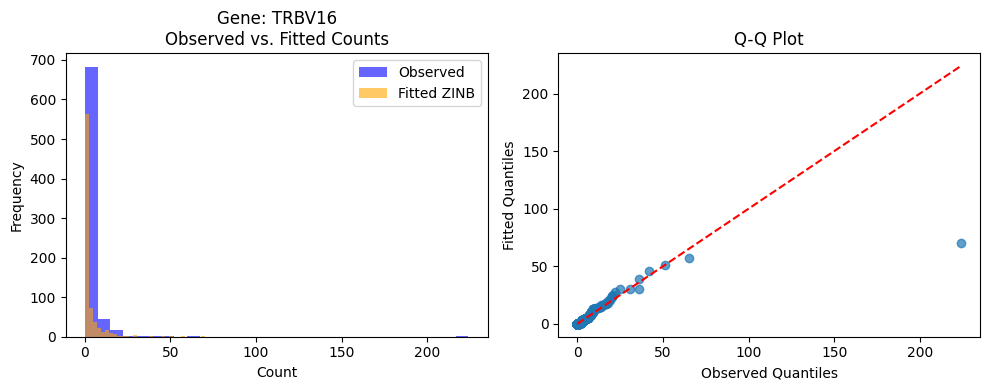

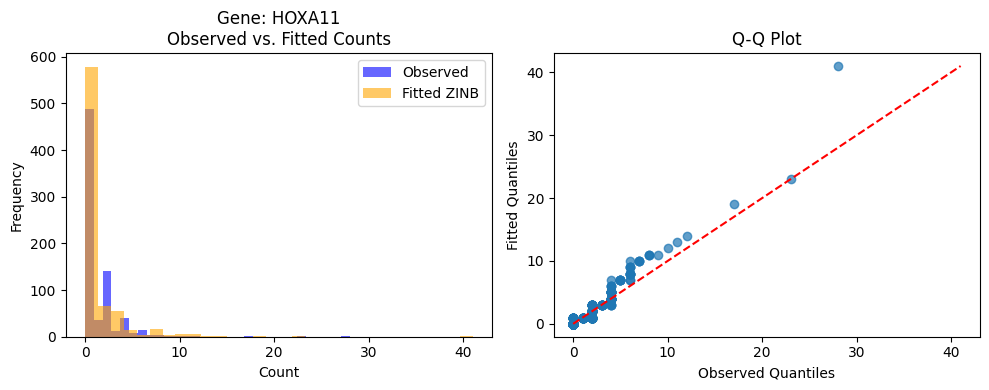

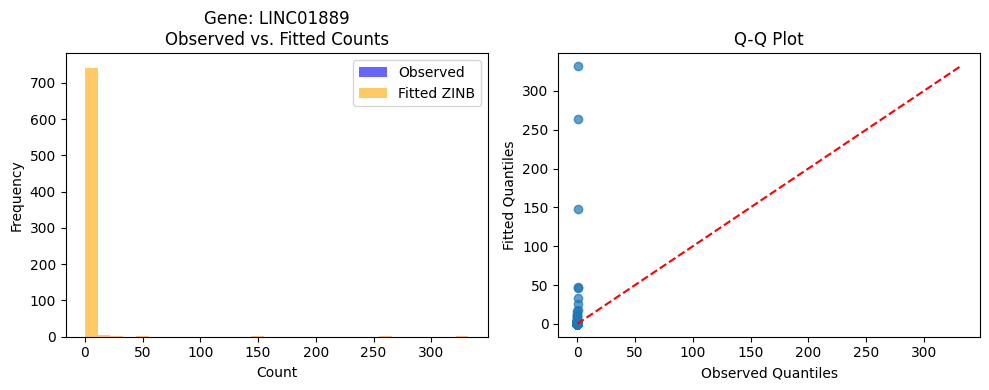

In [117]:
import scipy.stats as stats

# Pick a few random genes to visualize
num_genes_to_plot = 4
np.random.seed(42)
gene_indices = np.random.choice(non_expressed_matched.shape[0], num_genes_to_plot, replace=False)

for idx in gene_indices:
    gene_name = non_expressed_names_matched[idx, 1]
    observed_counts = non_expressed_matched[idx, :]
    
    # Get fitted ZINB parameters for this gene across all samples
    with torch.no_grad():
        mu, pi, theta = zinb_head.forward(Z_torch, size_factors_torch)
        mu_gene = mu[:, idx].cpu().numpy()
        pi_gene = pi[:, idx].cpu().numpy()
        theta_gene = theta[idx].cpu().numpy()
    
    # Simulate fitted ZINB samples for comparison
    n_samples = observed_counts.shape[0]
    zinb_samples = []
    for i in range(n_samples):
        # Zero-inflation
        if np.random.rand() < pi_gene[i]:
            zinb_samples.append(0)
        else:
            zinb_samples.append(np.random.negative_binomial(theta_gene, theta_gene/(theta_gene+mu_gene[i])))
    zinb_samples = np.array(zinb_samples)
    
    # Plot observed vs. fitted histogram
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(observed_counts, bins=30, alpha=0.6, label='Observed', color='blue')
    plt.hist(zinb_samples, bins=30, alpha=0.6, label='Fitted ZINB', color='orange')
    plt.title(f'Gene: {gene_name}\nObserved vs. Fitted Counts')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Q-Q plot
    plt.subplot(1,2,2)
    obs_sorted = np.sort(observed_counts)
    fit_sorted = np.sort(zinb_samples)
    min_len = min(len(obs_sorted), len(fit_sorted))
    plt.plot(obs_sorted[:min_len], fit_sorted[:min_len], 'o', alpha=0.7)
    plt.plot([0, max(obs_sorted.max(), fit_sorted.max())], [0, max(obs_sorted.max(), fit_sorted.max())], 'r--')
    plt.title('Q-Q Plot')
    plt.xlabel('Observed Quantiles')
    plt.ylabel('Fitted Quantiles')
    plt.tight_layout()
    plt.show()


In [118]:
# Compute log-likelihood for fitted model
with torch.no_grad():
    mu, pi, theta = zinb_head.forward(Z_torch, size_factors_torch)
    ll_fitted = -zinb_head.zinb_nll(non_expressed_matched_torch, mu, pi, theta).item()

# Compute log-likelihood for null model (e.g., mean of data, no zero-inflation)
mean_counts = non_expressed_matched.mean(axis=1, keepdims=True)
mean_counts_torch = torch.tensor(mean_counts.T, dtype=torch.float32)
mu_null = mean_counts_torch.expand_as(non_expressed_matched_torch)
pi_null = torch.zeros_like(mu_null)  # No zero-inflation
theta_null = torch.ones(non_expressed_matched.shape[0])  # Or use estimated theta

ll_null = -zinb_head.zinb_nll(non_expressed_matched_torch, mu_null, pi_null, theta_null).item()

pseudo_r2 = 1 - (ll_fitted / ll_null)
print(f"Pseudo-R² (explained deviance): {pseudo_r2:.3f}")

Pseudo-R² (explained deviance): -3.645
